In [ ]:
import music21
import math
import midiutil
import pqca
import random
import drawsvg as draw

In [ ]:
# Creates a 2D grid of random bits

class Bit_Generator:
    def __next__(self):
        return [[random.choice([0,1]) for i in range(0,9)] for j in range(0,4)]

BG = Bit_Generator()
next(BG)

[[1, 0, 0, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 1, 0, 1, 1, 0, 1],
 [0, 0, 1, 0, 1, 1, 1, 0, 1],
 [1, 0, 0, 0, 0, 0, 1, 1, 0]]

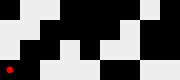

In [ ]:
# Drawing the bits grid as a .svg image

def draw_bits(grid, marked=None, mark_color=None):
    square_size = 20
    drawing = draw.Drawing(square_size * 9, square_size * 4)
    for row in range(4):
        for index, bit in enumerate(grid[row]):
            color = '#eeeeee' if bit else '#000000'
            rect = draw.Rectangle(index * square_size, (3 -row ) * square_size, square_size, square_size, fill = color)
            drawing.append(rect)
    if marked is None:
        marked = []
    for index, mark in enumerate(marked):
        x = mark[0]
        y = mark[1]
        color = "#ff0000" if mark_color is None else mark_color
        circle = draw.Circle(( x + 0.5) * square_size, (3.5-y) * square_size, square_size/6, fill = color)
        drawing.append(circle)
    return drawing

draw_bits(next(BG), [[0,0]])

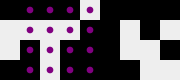

In [ ]:
# Setting up the grid so that it follows the CAMUS protocol:
# 1. The first column dicates the fundamental of the current triads' frequency
# 2. The next four columns are a sequence of triads by way of intervals above the fundamental
# 3. The final four columns describe the instrument which will play the notes
grid = next(BG)
'''draw_bits(grid, [[0, row] for row in range(0,4)], "red")
draw_bits(grid, [[column, row] for column in range(1,5) for row in range(0,4)], "green")
draw_bits(grid, [[column, row] for column in range(5,9) for row in range(0,4)], "purple")'''
def bit_breakdown(grid):
    """Split the large grid into appropriate subgrids."""
    return {"fundamental": [row[0] for row in grid],
            "triads": [row[1:5] for row in grid],
            "instruments": [row[5:9] for row in grid],
    }

bit_breakdown(grid)

# Determining the fundamental by the four bits in the first column (treat byte as a binary number)
def breakdown_to_semitone_shift(bits):
    return int("".join(map(str, bits)),2)

breakdown_to_semitone_shift(bit_breakdown(grid)["fundamental"])

# Determining the triads:
# the x coordinate of the cell gives the interval between the fundamental and the first note
# the y coordinate of the cell gives the interval between the first and second notes

draw_bits(grid, [[column, row] for column in range(1,5) for row in range(0,4)], "purple")



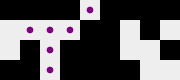

In [ ]:
# Determining the triads:
# the x coordinate of the cell gives the interval between the fundamental and the first note
# the y coordinate of the cell gives the interval between the first and second notes
def triad_bits_to_coordinate_sequence(triad_bits):
    triads = []
    for j in range(0, len(triad_bits)):
        for i in range(0,len(triad_bits[j])):
            if triad_bits[j][i]:
                triads.append([i,j])
    return triads

triad_bits_to_coordinate_sequence(bit_breakdown(grid)["triads"])
draw_bits(grid, map(lambda xy: [xy[0]+1,xy[1]], triad_bits_to_coordinate_sequence(bit_breakdown(grid)["triads"])), "purple")

In [ ]:
# For each white square, we generate a triad:

def intervals_to_triad(fundamental, coordinate):
    notes = []
    notes.append(fundamental)
    notes.append(notes[0] + coordinate[0]) # x coordinate determines first interval
    notes.append(notes[1] + coordinate[1]) # y coordinate determines second interval
    return notes

def triad_interval_sequence(bits):
    breakdown = bit_breakdown(bits)
    fundamental = breakdown_to_semitone_shift(breakdown["fundamental"])
    triad_bit_sequence = triad_bits_to_coordinate_sequence(breakdown["triads"])
    return [intervals_to_triad(fundamental, coordinate) for coordinate in triad_bit_sequence]

triad_interval_sequence(grid) # we show a list of triads as semitones above C4 note (base note)

[[6, 7, 7], [6, 7, 8], [6, 6, 8], [6, 7, 9], [6, 8, 10], [6, 9, 12]]

{'a': 1, 'b': 0, 'c': 1, 'd': 1, 'm': 0, 'n': 0, 'o': 0, 'p': 0}


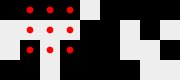

In [ ]:
# We use the following functions to check the values of the cells around our target cell:

def lookup(bit_grid, coordinates):
    '''Find the value at the specified point in the bit_grid.    
    If the coordinates fall outside of the grid then return 0.'''
    if coordinates[1] < 0 or coordinates[1] >= len(bit_grid):
        return 0
    if coordinates[0] < 0 or coordinates[0] >= len(bit_grid[0]):
        return 0
    return bit_grid[coordinates[1]][coordinates[0]]

def draw_neighbours(bits, point):
    return draw_bits(bits, [[x,y] for x in range(point[0]-1,point[0]+2) for y in range(point[1]-1,point[1]+2)])

def neighbours(bit_grid, coordinate):
    x_mid = coordinate[0]
    y_mid = coordinate[1]
    ordered = [lookup(bit_grid,[x,y]) 
            for y in (y_mid-1, y_mid, y_mid+1)
            for x in (x_mid-1, x_mid, x_mid+1)
           ]
    return {
        "a": ordered[1], # south
        "b": ordered[7], # north
        "c": ordered[5], # east
        "d": ordered[3], # west
        "m": ordered[0], # south-west
        "n": ordered[8], # north-east
        "o": ordered[2], # south-east
        "p": ordered[6]  # north-west
    }

print(neighbours(grid,[2,2]))
draw_neighbours(grid,[2,2])

In [ ]:
'''
We move through the points x and y looking at the value in the grids.
The first grid determines whether the triad (fundamental, fundamental + x, fundamental + x + y) is played.
The second grid determines which instruments will play that.
In order to have multiple instruments we will use the following scheme:
    neighbour a determines if the bottom note is on instrument 0 or 1
    neighbour b determines if the middle note is on instrument 0 or 1
    neighbour c determines if the top note is on instrument 0 or 1
'''

def mark_triad_and_instrument(bits, triad_coord):

    return draw_bits(bits, [[triad_coord[0]+1, triad_coord[1]],
                            [triad_coord[0]+5, triad_coord[1]-1],
                            [triad_coord[0]+6, triad_coord[1]],
                            [triad_coord[0]+5, triad_coord[1]+1]])

def instrument_from_triad_coord(bits, triad_coord):
    instrument_coord = [triad_coord[0]+5, triad_coord[0]]
    n = neighbours(bits, instrument_coord)
    return [n["a"], n["b"], n["c"]]
mark_triad_and_instrument(grid, [1,1])
print(instrument_from_triad_coord(grid, [1,1]))

[0, 1, 1]


{'entry': [1, 1, 0], 'exit': [0.0, 0.5, 0.0]}


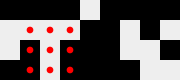

In [ ]:

'''
    a indicates whether the bottom note of the triad starts on the first beat of the bar or waits a little
    b indicates whether the middle note of the triad starts on the first beat of the bar or waits a little
    c indicates whether the upper note of the triad starts on the first beat of the bar or waits a little
    d determines how long the wait is. If 1 then wait a eight, if 0 then wait a quarter

    m indicates whether the bottom note of the triad goes to the end of the bar or finishes early
    n indicates whether the middle note of the triad goes to the end of the bar or finishes early
    o indicates whether the upper note of the triad goes to the end of the bar or finishes early
    p determines what finishes early means. If 1 then a eight early, if 0 then a quarter early
'''
def timings(bits, triad_coord, short_wait=0.5, long_wait=1):
    '''
    Given a triad coordinate find the lengths of the rests (if any) before and after the part is played.
    
    short_wait is the length of the rest if the appropriate cell's value is 1,
    and long_wait`is the length of the rest if the appropriate cell's value is 0.
    
    offset is used when concatenating data, and shifts all timings the specified amount.
    '''
    n = neighbours(bits, [triad_coord[0]+1, triad_coord[1]])
    entry = [n[direction] * (short_wait if n["d"] else long_wait) for direction in "abc"]
    exit = [n[direction] * (short_wait if n["p"] else long_wait) for direction in "mno"]
    return {"entry": entry, "exit": exit }

print(timings(grid, [1,1]))
draw_neighbours(grid,[2,1])


In [ ]:
def bits_to_triad_sequence(bits):
    breakdown = bit_breakdown(bits)
    fundamental = breakdown_to_semitone_shift(breakdown["fundamental"])
    triad_coordinates = triad_bits_to_coordinate_sequence(breakdown["triads"])
    triad_data = [{"intervals": intervals_to_triad(fundamental, coordinate),
                  "instruments": instrument_from_triad_coord(bits, coordinate),
                  "timings": timings(bits, coordinate)}
                  for coordinate in triad_coordinates] 
    return triad_data

print(bits_to_triad_sequence(grid))

def sequence_of_bit_grids_to_triads(list_of_bit_grids):
    return [triad 
            for bits in list_of_bit_grids
            for triad in bits_to_triad_sequence(bits)]

print(sequence_of_bit_grids_to_triads([grid, grid]))

def triads_to_instrument_parts(triad_data, offset = 0):
    instruments = [[],[]]
    for index, triad in enumerate(triad_data):
        for part in [0,1,2]:
            instruments[triad["instruments"][part]].append({
                "pitch": triad["intervals"][part],
                "entry": offset + index*3 + triad["timings"]["entry"][part],
                "exit": offset + (index+1)*3 - triad["timings"]["exit"][part]
            })
    return instruments

print(triads_to_instrument_parts(bits_to_triad_sequence(grid)))

def triads_to_voice_parts(triad_data):
    voices = [[],[],[]]
    for index, triad in enumerate(triad_data):
        for voice in [0,1,2]:
            voices[voice].append({
                "pitch": triad["intervals"][voice],
                "entry": index*3 + triad["timings"]["entry"][voice],
                "exit": (index+1)*3 - triad["timings"]["exit"][voice],
                "instrument": triad["instruments"][voice]
            })
    return voices

print(triads_to_voice_parts(bits_to_triad_sequence(grid)))

[{'intervals': [6, 7, 7], 'instruments': [0, 1, 1], 'timings': {'entry': [0, 1, 0], 'exit': [0, 0, 0]}}, {'intervals': [6, 7, 8], 'instruments': [0, 1, 1], 'timings': {'entry': [1, 1, 0], 'exit': [0.0, 0.5, 0.0]}}, {'intervals': [6, 6, 8], 'instruments': [0, 0, 0], 'timings': {'entry': [0.0, 0.0, 0.5], 'exit': [1, 0, 1]}}, {'intervals': [6, 7, 9], 'instruments': [0, 1, 1], 'timings': {'entry': [0.5, 0.0, 0.5], 'exit': [0, 0, 0]}}, {'intervals': [6, 8, 10], 'instruments': [1, 0, 1], 'timings': {'entry': [0.0, 0.0, 0.0], 'exit': [1, 1, 0]}}, {'intervals': [6, 9, 12], 'instruments': [1, 0, 0], 'timings': {'entry': [0, 0, 0], 'exit': [1, 0, 0]}}]
[{'intervals': [6, 7, 7], 'instruments': [0, 1, 1], 'timings': {'entry': [0, 1, 0], 'exit': [0, 0, 0]}}, {'intervals': [6, 7, 8], 'instruments': [0, 1, 1], 'timings': {'entry': [1, 1, 0], 'exit': [0.0, 0.5, 0.0]}}, {'intervals': [6, 6, 8], 'instruments': [0, 0, 0], 'timings': {'entry': [0.0, 0.0, 0.5], 'exit': [1, 0, 1]}}, {'intervals': [6, 7, 9],

In [ ]:
instrumentation = (music21.instrument.ElectricGuitar, music21.instrument.Saxophone)

import musical_scales
def int_to_midi(note_int, shift = 0):
    return musical_scales.Note(semitones_above_middle_c=note_int+12 + shift).midi

def bit_grid_to_chord_sequence_with_instruments_stream(triad_sequence, instruments=instrumentation):
    """Construct a stream as two parts, one for each instrument."""
    instrument_parts = triads_to_instrument_parts(triad_sequence)
    piece_length_in_beats = max(map(lambda note: note["exit"], [note
                                                                for part in instrument_parts
                                                                for note in part]))
    piece_length_in_bars = math.ceil(piece_length_in_beats / 3)

    def notes_in_bar(notes, bar):
        """Only those notes that sound in the given bar."""
        return [note for note in notes if note["entry"] >= bar*3 and note["exit"] <= (bar+1)*3]
    
    def notes_playing_at_time(notes, time):
        """Only those notes that sound in the given bar."""
        return [note for note in notes if note["entry"] <= time and note["exit"] > time]
    stream = music21.stream.Stream()
    stream.insert(0, music21.layout.ScoreLayout(isNew=True))
    parts = []
    for instrument_index, instrument in enumerate([instruments[0](), instruments[1]()]):
        notes_for_this_instrument = instrument_parts[instrument_index]
        part = music21.stream.Part(str(instrument))

        for bar in range(piece_length_in_bars):
            measure = music21.stream.Measure(number=bar)
            
            if bar == 0:
                measure.insert(0, instrument)
                measure.insert(0, music21.meter.TimeSignature('3/4'))
            relevant_notes = notes_in_bar(notes_for_this_instrument, bar)
            event_timings = sorted([note["entry"] for note in relevant_notes] +
                                   [note["exit"] for note in relevant_notes] +
                                   [bar*3, (bar+1)*3])

            timings_and_durations = []
            for index in range(len(event_timings) - 1):
                timings_and_durations.append(
                    (event_timings[index], event_timings[index+1] - event_timings[index]))
            
            chords_in_this_bar = []
            for timing, duration in timings_and_durations:
                if duration > 0:
                    notes_playing = notes_playing_at_time(
                        relevant_notes, timing)
                    music21_duration = music21.duration.Duration(duration)
                    if len(notes_playing) == 0:
                        measure.insert(timing - 3*bar, music21.note.Rest(
                            duration=music21_duration))
                    else:
                        pitches = [int_to_midi(note["pitch"]) for note in notes_playing]
                        chord = music21.chord.Chord(pitches, duration=music21_duration)
                        chords_in_this_bar.append(chord)
                        measure.insert(timing - 3*bar, chord)
                        
                        
            if len(chords_in_this_bar) < 2:
                pass
            else:
                for n in range(len(chords_in_this_bar)):
                    chords_in_this_bar[n].tie = music21.tie.Tie("continue")
                chords_in_this_bar[0].tie = music21.tie.Tie("start")
                chords_in_this_bar[-1].tie = music21.tie.Tie("stop")
            
            part.insert(3*bar, measure)
            
        parts.append(part)

    for part in parts:
        stream.insert(0, part)
        
    stream.insert(0, music21.layout.StaffGroup(parts, symbol="brace"))
    
    return stream


In [ ]:
def bit_grid_to_voices_stream(triad_sequence, instruments = []):
    """Construct a stream as three voices, ignoring instrument information."""
    stream = music21.stream.Score()
    stream.insert(0, music21.layout.ScoreLayout(isNew=True))
    
    parts = [music21.stream.Part() for i in range(3)]
    
    for index, instrument in enumerate(instruments):
        parts[index].insert(0, instrument())
    
    for index, triad in enumerate(triad_sequence):
        measures = [music21.stream.Measure(number=index) for i in range(3)]
        if index == 0:
            for m_index, measure in enumerate(measures):
                measure.insert(0, music21.meter.TimeSignature('3/4'))
        for voice in [0,1,2]:
            instrument_index = triad["instruments"][voice]
            entry = triad["timings"]["entry"][voice]
            if entry > 0:
                measures[voice].insert(0, music21.note.Rest(duration=music21.duration.Duration(entry)))
            exit = triad["timings"]["exit"][voice]
            note = music21.note.Note(int_to_midi(triad["intervals"][voice]),
                                     duration=music21.duration.Duration(3-exit-entry))
            measures[voice].insert(entry, note)
            if exit > 0:
                measures[voice].insert(3-exit, music21.note.Rest(duration=music21.duration.Duration(exit)))
        [parts[i].insert(3*index, measures[i]) for i in range(3)]
        
    for part in parts:
        stream.insert(0, part)
    stream.insert(0, music21.layout.StaffGroup(parts, symbol="brace"))
    return stream

In [ ]:
def bit_grids_to_midi_instrumentation_from_CAMUS(list_of_bit_grids, filename="temp1.midi", shift=0, tempo=120, instruments = instrumentation):
    midiFile = midiutil.MIDIFile(1)
    midiFile.addTempo(0,0,tempo)
    
    voice_parts = triads_to_voice_parts(sequence_of_bit_grids_to_triads(list_of_bit_grids))
    
    for voice, voice_part in enumerate(voice_parts):
        for note in voice_part:
            pitch = note["pitch"] + 42 + shift
            instrument =  instruments[note["instrument"]]().midiProgram
            entry = float(note["entry"])
            duration = float(note["exit"] - note["entry"])
            if duration > 0:
                midiFile.addProgramChange(0, voice, entry, instrument)
                midiFile.addNote(0, voice, pitch, entry, duration, 100)
    
    with open(filename, "wb") as output_file:
        midiFile.writeFile(output_file)

bit_grids_to_midi_instrumentation_from_CAMUS([grid])

In [ ]:
# QUANTUM
import qiskit

initial_state = [0] * 9 * 4
tes_1 = pqca.tessellation.n_dimensional([9,4],[1,2])
tes_2 = pqca.tessellation.n_dimensional([9,4],[3,1])

two_qubit_circuit = qiskit.QuantumCircuit(2)
two_qubit_circuit.cx(0,1)
two_qubit_circuit.h(0)
two_qubit_circuit.draw()

three_qubit_circuit = qiskit.QuantumCircuit(3)
three_qubit_circuit.cx(0,1)
three_qubit_circuit.x(1)
three_qubit_circuit.cx(1,2)
three_qubit_circuit.draw()

update_frame_1 = pqca.UpdateFrame(tes_1, qiskit_circuit=two_qubit_circuit)
update_frame_2 = pqca.UpdateFrame(tes_2,  qiskit_circuit=three_qubit_circuit)

automaton = pqca.Automaton(initial_state, [update_frame_1, update_frame_2], pqca.backend.qiskit())
automaton.update_circuit.draw()


┌───┐                                        
 q_0: ──■──┤ H ├────────────■───────────────────────────
      ┌─┴─┐└───┘            │                           
 q_1: ┤ X ├───────■─────────┼───────────────────────────
      └───┘┌───┐  │         │                           
 q_2: ──■──┤ H ├──┼─────────┼────■──────────────────────
      ┌─┴─┐└───┘  │         │    │                      
 q_3: ┤ X ├───────┼────■────┼────┼──────────────────────
      └───┘┌───┐  │    │  ┌─┴─┐  │  ┌───┐               
 q_4: ──■──┤ H ├──┼────┼──┤ X ├──┼──┤ X ├───────■───────
      ┌─┴─┐└───┘┌─┴─┐  │  ├───┤  │  └───┘       │       
 q_5: ┤ X ├─────┤ X ├──┼──┤ X ├──┼────■─────────┼───────
      └───┘┌───┐└───┘  │  └───┘┌─┴─┐  │  ┌───┐  │       
 q_6: ──■──┤ H ├───────┼───────┤ X ├──┼──┤ X ├──┼────■──
      ┌─┴─┐└───┘     ┌─┴─┐┌───┐└───┘  │  └───┘  │    │  
 q_7: ┤ X ├──────────┤ X ├┤ X ├──■────┼─────────┼────┼──
      └───┘┌───┐     └───┘└───┘  │    │       ┌─┴─┐  │  
 q_8: ──■──┤ H ├─────────────────┼────┼───────┤ X ├──┼──
      ┌─┴─┐└───┘                 │  ┌─┴─┐     └───┘  │  
 q_9: ┤ X ├──────────────────────┼──┤ X ├────────────┼──
      └───┘┌───┐                 │  └───┘          ┌─┴─┐
q_10: ──■──┤ H ├─────────────────┼─────────────────┤ X ├
      ┌─┴─┐└───┘               ┌─┴─┐               └───┘
q_11: ┤ X ├────────────────────┤ X ├────────────────────
      └───┘┌───┐               └───┘                    
q_12: ──■──┤ H ├────────────■───────────────────────────
      ┌─┴─┐└───┘            │                           
q_13: ┤ X ├───────■─────────┼───────────────────────────
      └───┘┌───┐  │         │                           
q_14: ──■──┤ H ├──┼─────────┼────■──────────────────────
      ┌─┴─┐└───┘  │         │    │                      
q_15: ┤ X ├───────┼────■────┼────┼──────────────────────
      └───┘┌───┐  │    │  ┌─┴─┐  │  ┌───┐               
q_16: ──■──┤ H ├──┼────┼──┤ X ├──┼──┤ X ├───────■───────
      ┌─┴─┐└───┘┌─┴─┐  │  ├───┤  │  └───┘       │       
q_17: ┤ X ├─────┤ X ├──┼──┤ X ├──┼────■─────────┼───────
      └───┘┌───┐└───┘  │  └───┘┌─┴─┐  │  ┌───┐  │       
q_18: ──■──┤ H ├───────┼───────┤ X ├──┼──┤ X ├──┼────■──
      ┌─┴─┐└───┘     ┌─┴─┐┌───┐└───┘  │  └───┘  │    │  
q_19: ┤ X ├──────────┤ X ├┤ X ├──■────┼─────────┼────┼──
      └───┘┌───┐     └───┘└───┘  │    │       ┌─┴─┐  │  
q_20: ──■──┤ H ├─────────────────┼────┼───────┤ X ├──┼──
      ┌─┴─┐└───┘                 │  ┌─┴─┐     └───┘  │  
q_21: ┤ X ├──────────────────────┼──┤ X ├────────────┼──
      └───┘┌───┐                 │  └───┘          ┌─┴─┐
q_22: ──■──┤ H ├─────────────────┼─────────────────┤ X ├
      ┌─┴─┐└───┘               ┌─┴─┐               └───┘
q_23: ┤ X ├────────────────────┤ X ├────────────────────
      └───┘┌───┐               └───┘                    
q_24: ──■──┤ H ├────────────■───────────────────────────
      ┌─┴─┐└───┘            │                           
q_25: ┤ X ├───────■─────────┼───────────────────────────
      └───┘┌───┐  │         │                           
q_26: ──■──┤ H ├──┼─────────┼────■──────────────────────
      ┌─┴─┐└───┘  │         │    │                      
q_27: ┤ X ├───────┼────■────┼────┼──────────────────────
      └───┘┌───┐  │    │  ┌─┴─┐  │  ┌───┐               
q_28: ──■──┤ H ├──┼────┼──┤ X ├──┼──┤ X ├───────■───────
      ┌─┴─┐└───┘┌─┴─┐  │  ├───┤  │  └───┘       │       
q_29: ┤ X ├─────┤ X ├──┼──┤ X ├──┼────■─────────┼───────
      └───┘┌───┐└───┘  │  └───┘┌─┴─┐  │  ┌───┐  │       
q_30: ──■──┤ H ├───────┼───────┤ X ├──┼──┤ X ├──┼────■──
      ┌─┴─┐└───┘     ┌─┴─┐┌───┐└───┘  │  └───┘  │    │  
q_31: ┤ X ├──────────┤ X ├┤ X ├──■────┼─────────┼────┼──
      └───┘┌───┐     └───┘└───┘  │    │       ┌─┴─┐  │  
q_32: ──■──┤ H ├─────────────────┼────┼───────┤ X ├──┼──
      ┌─┴─┐└───┘                 │  ┌─┴─┐     └───┘  │  
q_33: ┤ X ├──────────────────────┼──┤ X ├────────────┼──
      └───┘┌───┐                 │  └───┘          ┌─┴─┐
q_34: ──■──┤ H ├─────────────────┼─────────────────┤ X ├
      ┌─┴─┐└───┘     

In [ ]:
class Qubit_Generator:
    def __next__(self):
        thirty_six_bits = next(automaton)
        return [[thirty_six_bits[i+j] for j in range(9)] for i in range(4)]
QBG = Qubit_Generator()

bits = next(QBG)
bits

bit_grids_to_midi_instrumentation_from_CAMUS([bits])